#Self Explaining Structures Improve NLP Models: Reproducibility Study
###Group Members: Dhyay, Brian, Rathi 

**README:**
1. Save the folder submitted with this notebook on your drive. 
2. Mount your drive. 
3. The folder structure is as follows:
- project:
  - sst_data (SST5 Dataset)
  - snli_1.0 (SNLI Dataset)
  - interpretability (Extracted spans, incorrect samples for SST5)
  - interpret_snli (Extracted spans, incorrect samples for SNLI)
- The last two folders are populated during execution 

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import torch
from torch import nn
from transformers import RobertaModel, RobertaConfig
from transformers import get_linear_schedule_with_warmup, AdamW
from typing import List
import os
from functools import partial
from transformers import RobertaTokenizer
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from tqdm.notebook import tqdm
import string
import json

In [ ]:
assert torch.cuda.is_available(), "no GPU found, in Colab go to 'Edit->Notebook settings' and choose a GPU hardware accelerator"

device = torch.device("cuda")

The collate function takes in batched input ids, pads them to the maximum length, reshapes the labels and creates span indices. This data is fed into the model. 

In [ ]:
def collate(data):

    reformated_input = []
    bsz = len(data)
    batch_list = np.array(data)
    max_len = batch_list[:,2].max()

    seq_ids = torch.ones(bsz,max_len, dtype=data[0][0][0].dtype)
    labels = torch.from_numpy(batch_list[:,1].astype(np.int64)).unsqueeze(1)
    seq_lengths = torch.from_numpy(batch_list[:,2].astype(np.int64)).unsqueeze(1)
    reformated_input.append(seq_ids)
    reformated_input.append(labels)
    reformated_input.append(seq_lengths)

    for b in range(bsz):
      for ele in range(data[b][2]):
        reformated_input[0][b][ele] = data[b][0][ele]

    start_indices = []
    end_indices = []
    for i in range(1, max_len - 1):
        for j in range(i, max_len - 1):
            start_indices.append(i)
            end_indices.append(j)

    reformated_input.append(torch.LongTensor(start_indices))
    reformated_input.append(torch.LongTensor(end_indices))
      
    return reformated_input

The model is described in the class below, it consists of the following layers:
1. Intermediate - Roberta Base Transformer
2. SIC - Span Infor Collect Layer: FFN which performs the tanh operation
3. Interpretation - Assigns weights to each span 
4. Output - Computes output using weighted spans

In [ ]:
class SelfExplainingModel(nn.Module):
   def __init__(self):
      super().__init__()
      self.config = RobertaConfig.from_pretrained('roberta-base', output_hidden_states=False, num_labels=5)
      self.intermediate = RobertaModel.from_pretrained('roberta-base', num_labels=5).to(device)
      self.sic_w1 = nn.Linear(self.config.hidden_size, self.config.hidden_size)
      self.sic_w2 = nn.Linear(self.config.hidden_size, self.config.hidden_size)
      self.sic_w3 = nn.Linear(self.config.hidden_size, self.config.hidden_size)
      self.sic_w4 = nn.Linear(self.config.hidden_size, self.config.hidden_size)
      self.interpretation = nn.Linear(self.config.hidden_size, 1)
      self.output = nn.Linear(self.config.hidden_size, self.config.num_labels)
   def forward(self, input, start, end):
      mask = (input != 1).long()
      output = self.intermediate(input, attention_mask=mask)[0]
      output = output.to(device)
      w1h = self.sic_w1(output)
      w2h = self.sic_w2(output)
      w3h = self.sic_w3(output)
      w4h = self.sic_w4(output)
      w1hi = torch.index_select(w1h, 1, start)
      w2hj = torch.index_select(w2h, 1, end)
      w3hi = torch.index_select(w3h, 1, start)
      w3hj = torch.index_select(w3h, 1, end)
      w4hi = torch.index_select(w4h, 1, start)
      w4hj = torch.index_select(w4h, 1, end)
      output = w1hi + w2hj + (w3hi - w3hj) + torch.mul(w4hi, w4hj)
      hij = torch.tanh(output)
      span = self.interpretation(hij).squeeze(-1)
      aij = F.softmax(span, dim=1)
      output = (aij.unsqueeze(-1) * hij).sum(dim = 1)
      output = self.output(output)
      # print(output.shape)
      # print(output)
      output_softmax = F.softmax(output, dim=1)
      # print(output_softmax.shape)
      # print(output_softmax)
      return output, output_softmax, aij


SST Dataset Class

In [ ]:
def preprocess(text, tokenizer):
    text = text.strip()
    if text[-1] == ".":
        text = text[:-1]
    text = tokenizer.encode(text, add_special_tokens=False)
    text = text[:510]
    return text

In [ ]:
class SSTDataset(torch.utils.data.Dataset):
    def __init__(self, path, mode):
        super().__init__()
        self.max_length = 512
        with open(path + mode + '.txt', 'r', encoding='utf8') as f:
            self.data = f.readlines()
        self.tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, ind):
        data = self.data[ind]
        label, input = data.split('\t', 1)
        input = preprocess(input, self.tokenizer)
        length = torch.LongTensor([len(input) + 2])
        input = torch.LongTensor([0] + input + [2])
        label = torch.LongTensor([int(label)])
        return input, label, length

In [ ]:
def train(model, dataloader, epochs, reg_lambda):
    train_loss = []
    val_acc = []
    for epoch in range(epochs):
        print('Epoch: ', epoch)
        loss = 0
        model.train()
        for ind, (input, label, length, start, end) in enumerate(tqdm(dataloader)):
            model.zero_grad()
            # optimizer.zero_grad()
            output, output_softmax, a_ij = model(input.cuda(), start.cuda(), end.cuda())
            output_labels = torch.argmax(output_softmax, dim=-1).cuda()
 
            label = label.view(-1).cuda()
            loss = criterion(output, label) - reg_lambda*a_ij.pow(2).sum(dim=1).mean()
          
            loss.backward()
            optimizer.step()
            loss += loss.item()
        # test()
        scheduler.step()
        model.eval()
        _, _, _, acc, _ = test(model, valloader, isFileOutput=False)
        print('Train loss: ', loss)
        train_loss.append(loss.item())
        print('Validation Acc: ', acc)
        val_acc.append(acc.item())
    return train_loss, val_acc


In [ ]:
def getSpans(input,label,length,start,end,pred,aij,k=5):
  topkvalues, topkindices = torch.topk(aij, k)
  spans = []
  explainers = []
  incorrect_labels = []
  avg_span_length = 0
  span_len = 0
  c = 0
  for i in range(input.shape[0]):
    c += 1
    sent_ids = input[i].tolist()
    # print(sent_ids)
    tok = RobertaTokenizer.from_pretrained('roberta-base')
    sent = tok.decode(sent_ids, skip_special_tokens=True)
    for j in range(5):
      max_prob = topkvalues[i][j]
      span_sent = tok.decode(sent_ids[start[topkindices[i][j]]:end[topkindices[i][j]]+1],skip_special_tokens=True)
      sent_before_span = tok.decode(sent_ids[:start[topkindices[i][j]]],skip_special_tokens=True)
      sent_after_span = tok.decode(sent_ids[end[topkindices[i][j]]+1:],skip_special_tokens=True)
      line0 = sent_before_span + '【' + span_sent + '】' + sent_after_span
      explainers.append(format('%.4f' % max_prob) + "->" + line0 + '\n')
      if(j==0):
        span_len += end[topkindices[i][j]] - start[topkindices[i][j]] + 1
        line1 = str(label[i].item()) + '\t' + span_sent + '\n'
        spans.append(line1)
        if(pred[i] != label[i]):
          line2 = 'Correct: ' + str(label[i].item()) + '\t' + 'Predicted: ' + str(pred[i].item()) + '\t' + line0 + '\n'
          incorrect_labels.append(line2)
    avg_span_length = span_len/c
  return spans, explainers, incorrect_labels, avg_span_length



In [ ]:
def test(model, testloader, isFileOutput=False):
    model.eval()
    correct = 0
    spans_list = []
    explainers_list = []
    incorrect_labels_list = []
    span_len = 0
    c = 0
    with torch.no_grad():
      for ind, (input, label, length, start, end) in enumerate(tqdm(testloader)):
          # print(input)
          c+=1
          output, output_softmax, aij = model(input.cuda(), start.cuda(), end.cuda())
          # print(output_softmax)
          label = label.reshape(output_softmax.shape[0]).cuda()
          pred = torch.argmax(output_softmax, dim=-1)
          if (isFileOutput):
            spans, explainers, incorrect_labels, avg_span_length = getSpans(input,label,length,start,end,pred,aij)
            spans_list.append(spans)
            explainers_list.append(explainers)
            incorrect_labels_list.append(incorrect_labels)
            span_len += avg_span_length
        
          count = (pred == label).sum()
          correct = correct + count
    print('Accuracy: ', correct/len(testloader.dataset))
    print('Avg span length: ', span_len/c)
    acc = correct/len(testloader.dataset)
    return spans_list, explainers_list, incorrect_labels_list, acc, span_len/c

Experiments and Training on the SST-5 Dataset

In [ ]:
path = '/content/drive/MyDrive/project/sst_data/'
train_iter = SSTDataset(path, mode="train")
test_iter = SSTDataset(path, mode="test")
val_iter = SSTDataset(path, mode="dev")
dataloader = DataLoader(train_iter, batch_size=10, shuffle=False, collate_fn=partial(collate))
testloader = DataLoader(test_iter, batch_size=10, shuffle=False, collate_fn=partial(collate))
valloader = DataLoader(val_iter, batch_size=10, shuffle=False, collate_fn=partial(collate))

Hyperparameters

In [ ]:
model = SelfExplainingModel().to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
optimizer = AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()
reg_lambda = 1
num_epochs = 20
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0.1*len(dataloader), num_training_steps=len(dataloader))

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
train_loss, val_acc = train(model, dataloader, num_epochs, reg_lambda)

In [ ]:
#saving the model checkpoint
EPOCH = num_epochs
PATH = "/content/drive/MyDrive/project/orig_train_model.pt"
LOSS = 1.2227 #replace with obtained loss

torch.save({
            'epoch': EPOCH,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': LOSS,
            }, PATH)

In [ ]:
#loading model checkpoint
PATH = "/content/drive/MyDrive/project/orig_train_model.pt"
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

In [ ]:
#Test
spans, explainers, incorrect_labels, acc, avg_span_length = test(model, testloader, isFileOutput=True)

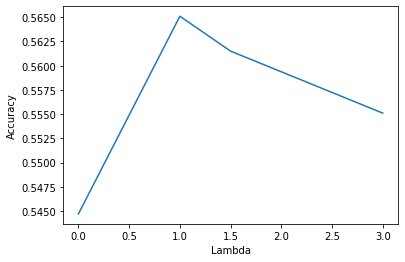

In [ ]:
import matplotlib.pyplot as plt
l = [0,1,1.5,3]
accs = [0.5447,0.5651,0.5615,0.5551]
plt.plot(l,accs)
plt.xlabel("Lambda")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
#Save test spans and results
path = '/content/drive/MyDrive/project/interpretability/'
with open(path + 'explainers.txt', 'w', encoding='utf8') as f:
  for item in explainers:
    for ele in item:
      f.write(str(ele))
with open(path + 'spans.txt', 'w', encoding='utf8') as f:
  for item in spans:
    for ele in item:
      f.write(str(ele))
with open(path +  'incorrect_labels.txt', 'w', encoding='utf8') as f:
  for item in incorrect_labels:
    for ele in item:
      f.write(str(ele))

In [ ]:
#Training on original train and testing on spans
testspan_iter = SSTDataset(path, mode="spans")
testspan_loader = DataLoader(testspan_iter, batch_size=10, shuffle=False, collate_fn=partial(collate))
spans, explainers, incorrect_labels, acc, avg_span_length = test(model, testspan_loader, isFileOutput=True)

In [ ]:
#Save test spans and results
spans, explainers, incorrect_labels, acc = test(dataloader, isFileOutput=True)
with open(path + 'train_explainers.txt', 'w', encoding='utf8') as f:
  for item in explainers:
    for ele in item:
      f.write(str(ele))
with open(path + 'train_spans.txt', 'w', encoding='utf8') as f:
  for item in spans:
    for ele in item:
      f.write(str(ele))
with open(path +  'train_incorrect_labels.txt', 'w', encoding='utf8') as f:
  for item in incorrect_labels:
    for ele in item:
      f.write(str(ele))

In [ ]:
#Training on span train
trainspan_iter = SSTDataset(path, mode="train_spans")
trainspan_loader = DataLoader(trainspan_iter, batch_size=10, shuffle=False, collate_fn=partial(collate))
train(model, trainspan_loader, num_epochs, reg_lambda)

In [ ]:
EPOCH = num_epochs
PATH = "/content/drive/MyDrive/project/span_train_model.pt"
LOSS = 2.6895 #change to obtained loss

torch.save({
            'epoch': EPOCH,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': LOSS,
            }, PATH)

In [ ]:
#Testing on orig test
spans, explainers, incorrect_labels, acc, avg_span_length = test(model, testloader, isFileOutput=True)

In [ ]:
#Testing on span test
spans, explainers, incorrect_labels, acc, avg_span_length = test(testspan_loader, isFileOutput=True)

SNLI Dataset Class

In [ ]:
class SNLIDataset(torch.utils.data.Dataset):
    def __init__(self, path, mode):
        super().__init__()
        self.max_length = 512
        self.data = []
        self.input1 = []
        self.input2 = []
        self.label = []
        labels = {"contradiction": 0, 'neutral': 1, "entailment": 2}
        with open(path + 'snli_1.0_' + mode + '.jsonl', 'r', encoding='utf8') as f:
            self.data = [json.loads(line) for line in f]
        for data in self.data:
            if data['gold_label'] not in labels:
                continue
            self.input1.append(data['sentence1'])
            self.input2.append(data['sentence2'])
            self.label.append(labels[data['gold_label']])
        self.tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, ind):
        in1 = self.input1[ind]
        in2 = self.input2[ind]
        label = self.label[ind]
        inp = preprocess(in1, self.tokenizer) + [2] + preprocess(in2, self.tokenizer)
        length = torch.LongTensor([len(inp) + 2])
        input = torch.LongTensor([0] + inp + [2])
        label = torch.LongTensor([label])
        return input, label, length

In [ ]:
path = '/content/drive/MyDrive/project/snli_1.0/'
train_iter = SNLIDataset(path, mode="train")
test_iter = SNLIDataset(path, mode="test")
val_iter = SNLIDataset(path, mode="dev")
dataloader = DataLoader(train_iter, batch_size=12, shuffle=False, collate_fn=partial(collate))
testloader = DataLoader(test_iter, batch_size=12, shuffle=False, collate_fn=partial(collate))
valloader = DataLoader(val_iter, batch_size=12, shuffle=False, collate_fn=partial(collate))

In [ ]:
model = SelfExplainingModel().to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
optimizer = AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()
reg_lambda = 1
num_epochs = 10
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0.1*len(dataloader), num_training_steps=len(dataloader))

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
train_loss, val_acc = train(model, dataloader, num_epochs, reg_lambda)

In [ ]:
spans, explainers, incorrect_labels, acc, avg_span_length = test(model, testloader, isFileOutput=True)

In [ ]:
path = '/content/drive/MyDrive/project/interpret_snli/'

with open(path + 'snli_1.0_test_explainers.jsonl', 'w', encoding='utf8') as f:
  for item in explainers:
    for ele in item:
      json.dumps(ele)
with open(path + 'snli_1.0_test_spans.jsonl', 'w', encoding='utf8') as f:
  for item in spans:
    for ele in item:
      json.dumps(ele)
with open(path +  'snli_1.0_test_incorrect_labels.jsonl', 'w', encoding='utf8') as f:
  for item in incorrect_labels:
    for ele in item:
      json.dumps(ele)

In [ ]:
path = '/content/drive/MyDrive/project/interpret_snli/'
test_spans_iter = SNLIDataset(path, mode="test_spans")
test_spans_loader = DataLoader(test_spans_iter, batch_size=10, shuffle=False, collate_fn=partial(collate))

In [ ]:
#The other experiments for F-S, S-F and S-S can be repeated as described above for SST-5